In [1]:
# import necessary libraries
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
from mango import Tuner, scheduler
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier

c:\Users\Amos Choo\Desktop\a2-binf7000\env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# load dataset

dna_meth = pd.read_csv('G11_lung_dna-meth.csv', sep=',')
gene_expr = pd.read_csv('G11_lung_gene-expr.csv', sep=',')
cpg_annot = pd.read_csv("CpG_hg19_annot.csv")

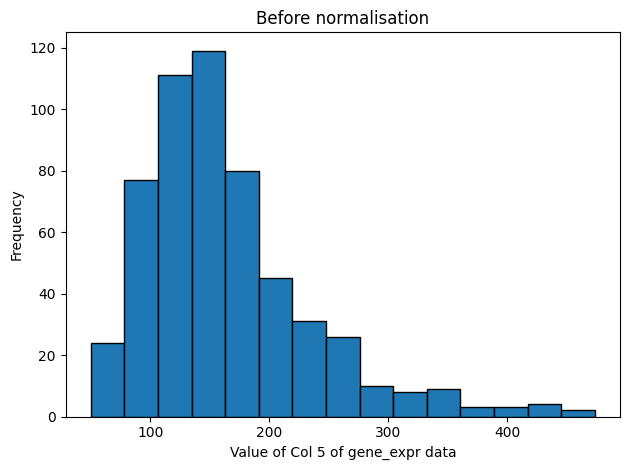

In [3]:
fig, axs = plt.subplots(nrows=1)

# Before normalization, demo to show the differences of transformation
axs.hist(gene_expr.iloc[:, 5], bins=15, edgecolor='black')
axs.set_title('Before normalisation')

axs.set_xlabel('Value of Col 5 of gene_expr data')
axs.set_ylabel('Frequency')
plt.tight_layout()
plt.show()

In [4]:
# Normalization of data by log2 transformation

dna_meth[dna_meth.columns[2:]] = np.log2(
    dna_meth[dna_meth.columns[2:]] + 0.001)
gene_expr[gene_expr.columns[2:]] = np.log2(
    gene_expr[gene_expr.columns[2:]] + 0.001)

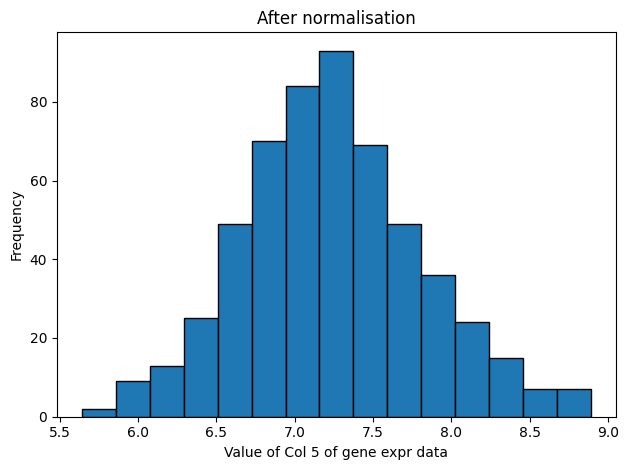

In [5]:
fig, axs = plt.subplots(nrows=1)

axs.hist(gene_expr.iloc[:, 5], bins=15, edgecolor='black')
axs.set_title('After normalisation')

axs.set_xlabel('Value of Col 5 of gene expr data')
axs.set_ylabel('Frequency')
plt.tight_layout()
plt.show()


In [4]:
# Get the top log fold change in cpg and genes

solid_tissue_normal_df = dna_meth[dna_meth['Label']
                                  == 'Solid Tissue Normal'].iloc[:, 2:]
primary_tumor_df = dna_meth[dna_meth['Label'] == 'Primary Tumor'].iloc[:, 2:]

# Calculate the mean methylation level for each CpG site in each group
mean_solid_tissue_normal = solid_tissue_normal_df.mean()
mean_primary_tumor = primary_tumor_df.mean()

# # Calculate the log-fold change for each CpG site
logfc_cpg = np.log10((mean_primary_tumor+0.0001) /
                     (mean_solid_tissue_normal+0.0001))

largestlfc_12cpgs = logfc_cpg.abs().nlargest(12)
largestlfc_12cpgs

solid_tissue_normal_df = gene_expr[gene_expr['Label']
                                   == 'Solid Tissue Normal'].iloc[:, 2:]
primary_tumor_df = gene_expr[gene_expr['Label'] == 'Primary Tumor'].iloc[:, 2:]

mean_solid_tissue_normal = solid_tissue_normal_df.mean()
mean_primary_tumor = primary_tumor_df.mean()

# # # Calculate the log-fold change for each gene
logfc_gene = np.log10((mean_primary_tumor + 0.0001) /
                      (mean_solid_tissue_normal + 0.0001))

largestlfc_10genes = logfc_gene.abs().nlargest(10)
largestlfc_10genes

VAX1.11023         2.853854
ABRA.137735        2.679544
FAM5C.339479       2.517137
TLX1.3195          2.502727
C8orf56.157556     2.420262
C6orf123.26238     2.225433
ACRV1.56           2.154985
ANXA10.11199       2.119681
GPR111.222611      2.055915
ALS2CR12.130540    2.010626
dtype: float64

In [5]:
# Define a mapping dictionary
label_mapping = {'Solid Tissue Normal': 0, 'Primary Tumor': 1}

# Use the dictionary to replace the labels in dna_meth
dna_meth['Label'] = dna_meth['Label'].replace(label_mapping)

# Use the dictionary to replace the labels in gene_expr
gene_expr['Label'] = gene_expr['Label'].replace(label_mapping)

In [6]:
# Feature selection by lit review (refer to document for details)
# last two genes are selected arbitrarily
genes_lit_review = ["KRAS.3845", "RAF1.5894"]
cpg_lit_review = []

In [7]:
# selecting gene that starts with RAS based on logfold change
ras_top8_genes = logfc_gene[logfc_gene.index.str.startswith(
    'RAS')].abs().nlargest(8)


for i in ras_top8_genes.index:
    genes_lit_review.append(i)
genes_lit_review

['KRAS.3845',
 'RAF1.5894',
 'RASAL1.8437',
 'RASGRF1.5923',
 'RASL10A.10633',
 'RASGRP4.115727',
 'RASGEF1C.255426',
 'RASGRP2.10235',
 'RASEF.158158',
 'RASL12.51285']

In [8]:
# selecting cpg that that has TP53,MGMT,CDKN2A,BRCA, MLH1, CDH1, TIMP-3, ER based pm logfold change
logfc_cpg

cpg_gene = ['TP53', 'MGMT', 'CDKN2A', 'BRCA1', 'MLH1', 'CDH1', 'TIMP-3', 'ER']

selected_rows = pd.Series([False]*len(cpg_annot), index=cpg_annot.index)

# Check each gene
for gene in cpg_gene:
    selected_rows |= (cpg_annot['UCSC_RefGene_Name'].str.startswith(
        gene) | cpg_annot['UCSC_RefGene_Name'].str.endswith(gene))

# Use the boolean Series to select the rows
selected = cpg_annot[selected_rows][['Unnamed: 0', 'UCSC_RefGene_Name']]
selected

,Unnamed: 0,UCSC_RefGene_Name
769,cg05872222,ERCC6L;PIN4
1519,cg12747864,ERCC6L;ERCC6L;PIN4
1565,cg13192155,ERAS
1566,cg13192819,ERCC6L;PIN4
2784,cg24671250,ERCC6L;PIN4
...,...,...
478673,cg18413706,ERG;ERG;ERG;ERG
478963,cg21578987,ERG;ERG
479119,cg23340514,ERG;ERG;ERG;ERG
479406,cg26108843,ERG;ERG


In [9]:
# Convert the dictionary to a DataFrame
logfc_df = pd.DataFrame(list(logfc_cpg.items()),
                        columns=['Unnamed: 0', 'logFC'])

# Merge the selected DataFrame with the logfc DataFrame
merged_df = pd.merge(selected, logfc_df, on='Unnamed: 0')
merged_df

# Sort by 'logFC' in descending order and get the top 8 rows
top_8_cpg = merged_df.sort_values(by='logFC', ascending=False).head(8)

In [10]:
# combining the cg values
cg_values = largestlfc_12cpgs.index.tolist()
cg_values_lit_review = top_8_cpg['Unnamed: 0'].tolist()

combined_cg_values = cg_values + cg_values_lit_review
combined_cg_values

['cg10243459',
 'cg19006220',
 'cg22475974',
 'cg14642259',
 'cg18155853',
 'cg06332339',
 'cg20691436',
 'cg08040429',
 'cg09473364',
 'cg03899721',
 'cg14699932',
 'cg17247026',
 'cg14210311',
 'cg16681083',
 'cg05003554',
 'cg04607251',
 'cg26458142',
 'cg06170283',
 'cg09682051',
 'cg04486940']

In [11]:
# combining the gene values
gene_values = largestlfc_10genes.index.tolist()
gene_values_lit_review = genes_lit_review

combined_gene_values = gene_values + gene_values_lit_review
combined_gene_values

['VAX1.11023',
 'ABRA.137735',
 'FAM5C.339479',
 'TLX1.3195',
 'C8orf56.157556',
 'C6orf123.26238',
 'ACRV1.56',
 'ANXA10.11199',
 'GPR111.222611',
 'ALS2CR12.130540',
 'KRAS.3845',
 'RAF1.5894',
 'RASAL1.8437',
 'RASGRF1.5923',
 'RASL10A.10633',
 'RASGRP4.115727',
 'RASGEF1C.255426',
 'RASGRP2.10235',
 'RASEF.158158',
 'RASL12.51285']

In [12]:
# feature filtering
filtered_dna_meth = dna_meth[combined_cg_values + ['Label']]
filtered_dna_meth

,cg10243459,cg19006220,cg22475974,cg14642259,cg18155853,cg06332339,cg20691436,cg08040429,cg09473364,cg03899721,...,cg17247026,cg14210311,cg16681083,cg05003554,cg04607251,cg26458142,cg06170283,cg09682051,cg04486940,Label
0,-0.017148,-0.017720,-0.011685,-0.019211,-0.016043,-0.013674,-0.028265,-0.025634,-0.016630,-0.027175,...,-0.014708,-0.014871,-0.034525,-0.136792,-0.104802,-0.153676,-0.086304,-0.057282,-0.186736,0
1,-1.179600,-1.277810,-0.925555,-0.725084,-0.341728,-0.686310,-1.698758,-0.573638,-0.514650,-0.637023,...,-0.479063,-0.019912,-0.026738,-0.745391,-1.307288,-0.822917,-0.488481,-0.104371,-0.180246,1
2,-0.010810,-0.014318,-0.010098,-0.018248,-0.012049,-0.015016,-0.021248,-0.018112,-0.020831,-0.014889,...,-0.015315,-0.014200,-0.032759,-0.095338,-0.082229,-0.235289,-0.086337,-0.073511,-0.153115,0
3,-0.346212,-0.940286,-0.050481,-0.324511,-0.013205,-1.013107,-0.043228,-0.030246,-0.757702,-0.701240,...,-0.525911,-0.475887,-0.944493,-0.297625,-0.314849,-0.318658,-0.134396,-0.068041,-0.812812,1
4,-0.017630,-0.016525,-0.014594,-0.019490,-0.016660,-0.011917,-0.032665,-0.020730,-0.019648,-0.014028,...,-0.024004,-0.021216,-0.047671,-0.098680,-0.083833,-0.145618,-0.086630,-0.267078,-0.171340,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
407,-2.153998,-2.031188,-1.504297,-0.292810,-1.225495,-1.359317,-0.603892,-1.760663,-1.609779,-1.191267,...,-1.678718,-1.178669,-1.460426,-0.469155,-0.260278,-1.083581,-0.317897,-0.655311,-1.477547,1
408,-1.086116,-0.931839,-0.699932,-0.139284,-1.149454,-0.838640,-1.472615,-0.799349,-0.784084,-0.279797,...,-0.769466,-0.730718,-0.993665,-1.120444,-0.666493,-1.015896,-0.354750,-0.597858,-1.068025,1
409,-1.024556,-0.890607,-0.674992,-0.731354,-0.026802,-0.706818,-1.397542,-1.210672,-0.866685,-0.072547,...,-0.143325,-0.717626,-1.016195,-1.037177,-0.435113,-0.636171,-0.513164,-0.655641,-1.161513,1
410,-0.204206,-0.022679,-0.023215,-0.021541,-1.922921,-0.015695,-0.027084,-3.238883,-0.017585,-2.207853,...,-2.254128,-0.021410,-0.024320,-0.112980,-0.157989,-0.104438,-0.110464,-0.482251,-0.155681,1


In [13]:
# feature filtering
filtered_gene_expr = gene_expr[combined_gene_values + ['Label']]
filtered_gene_expr

,VAX1.11023,ABRA.137735,FAM5C.339479,TLX1.3195,C8orf56.157556,C6orf123.26238,ACRV1.56,ANXA10.11199,GPR111.222611,ALS2CR12.130540,...,RAF1.5894,RASAL1.8437,RASGRF1.5923,RASL10A.10633,RASGRP4.115727,RASGEF1C.255426,RASGRP2.10235,RASEF.158158,RASL12.51285,Label
0,0.656084,-9.965784,1.977463,5.864649,0.786931,-9.965784,2.462785,0.656084,4.410124,1.977463,...,10.388188,7.626722,4.047573,2.655398,4.903149,0.656084,3.655283,5.921981,7.481728,1
1,-9.965784,-9.965784,0.928958,-9.965784,0.669027,2.098487,0.928958,6.428101,-9.965784,-0.070209,...,10.933161,4.735647,6.490496,2.098487,4.882482,-9.965784,5.195064,5.972654,7.180913,1
2,0.247806,-9.965784,2.054328,-9.965784,1.138683,-0.750979,0.832363,5.129295,1.247198,-0.750979,...,10.506354,3.334211,3.770279,1.569005,4.200881,-9.965784,3.054137,5.890490,6.953980,1
3,-9.965784,1.037242,4.358523,1.037242,-0.058894,0.622462,2.844084,0.037874,1.621946,-0.960721,...,10.993266,6.428859,2.621712,1.844265,5.636468,0.037874,4.496021,5.856729,8.735234,1
4,-9.965784,-0.342269,4.865355,-1.340441,-9.965784,0.242084,2.241108,-9.965784,1.463727,0.656725,...,11.037936,8.206604,6.759153,1.463727,4.328348,-1.340441,6.210461,8.105006,7.526225,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
547,7.378440,-1.269164,-1.269164,-0.270904,-0.647467,1.535257,1.312897,1.049979,-1.269164,-0.270904,...,10.692082,8.325436,3.186976,3.534858,3.771875,0.313478,5.917229,7.149454,5.760830,1
548,1.334740,-9.965784,-1.247423,-0.249136,-9.965784,1.071831,0.750006,0.750006,0.750006,1.749620,...,10.436567,7.119887,3.208783,3.141678,4.556607,-9.965784,6.224943,5.089083,7.477119,1
549,-9.965784,-9.965784,1.104605,-0.893518,0.229465,1.689344,0.105276,1.104605,2.689098,1.911653,...,10.764364,7.253678,5.425882,2.911461,3.627595,-9.965784,5.790449,5.351886,7.243482,1
550,-9.965784,-0.322469,-0.906440,-9.965784,-1.904008,2.898344,2.948975,-1.904008,2.178587,-0.906440,...,10.965925,7.964253,2.791460,0.898944,1.091463,2.339023,3.448491,8.132467,5.430687,1


In [14]:
# ---------------------------------------
# First we will deal with CpG sites datasets
# First we split the data into training and test sets

X = filtered_dna_meth.drop('Label', axis=1)
y = filtered_dna_meth['Label']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)

In [15]:
# We will then run a hyperparameter tuning to find the best parameters for the model
param_space = dict(min_samples_split=range(2, 10), n_estimators=range(75, 150), min_samples_leaf=range(
    1, 10), max_features=["sqrt", "log2", None], criterion=["gini", "entropy"])


@scheduler.serial
def objective(**params):
    clf = RandomForestClassifier(**params)
    score = cross_val_score(clf, X_train, y_train, cv=10).mean()
    return score


tuner = Tuner(param_space, objective, {'num_iteration': 30})
results = tuner.maximize()
print('best parameters:', results['best_params'])
print('best accuracy:', results['best_objective'])

Best score: 0.9870967741935484: 100%|██████████| 30/30 [05:25<00:00, 10.87s/it]

best parameters: {'criterion': 'gini', 'max_features': 'log2', 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 104}
best accuracy: 0.9870967741935484


In [16]:
# fit the model with the best parameters
params = results['best_params']
params = {'criterion': 'gini', 'max_features': 'log2', 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 104}
# or hardcode the best parameters
# clf_dna_meth = RandomForestClassifier(criterion="gini", max_features='log2',min_samples_leaf=1, min_samples_split=3, n_estimators=95)
clf_dna_meth = RandomForestClassifier(criterion=params['criterion'], max_features=params['max_features'],
                                      min_samples_leaf=params['min_samples_leaf'], min_samples_split=params['min_samples_split'], n_estimators=params['n_estimators'])
clf_dna_meth.fit(X_train, y_train)

RandomForestClassifier(max_features='log2', min_samples_leaf=9,
                       min_samples_split=4, n_estimators=104)

In [17]:
# Make predictions
y_pred = clf_dna_meth.predict(X_test)

# Check the F1 score of the model
print("F1 Score", f1_score(y_test, y_pred))

F1 Score 0.9944134078212291


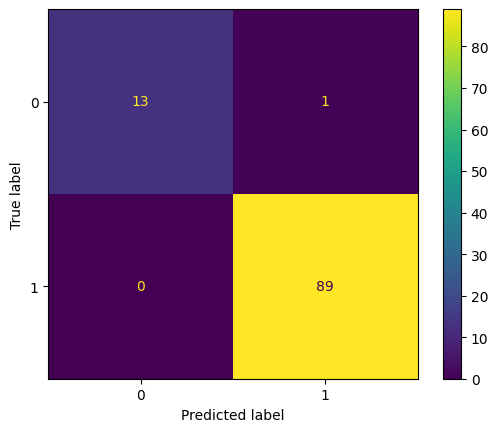

In [18]:
cm_dna_meth = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_dna_meth)
disp.plot()
plt.show()

In [20]:
# Now repeat the process for gene expression dataset

X = filtered_gene_expr.drop('Label', axis=1)
y = filtered_gene_expr['Label']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)

In [21]:
param_space = dict(min_samples_split=range(2, 10), n_estimators=range(75, 150), min_samples_leaf=range(
    1, 10), max_features=["sqrt", "log2", None], criterion=["gini", "entropy"])


@scheduler.serial
def objective(**params):
    clf = RandomForestClassifier(**params)
    score = cross_val_score(clf, X_train, y_train, cv=10).mean()
    return score


tuner = Tuner(param_space, objective, {'num_iteration': 30})
results = tuner.maximize()
print('best parameters:', results['best_params'])
print('best accuracy:', results['best_objective'])

Best score: 0.9975609756097562: 100%|██████████| 30/30 [05:41<00:00, 11.37s/it]

best parameters: {'n_estimators': 104, 'min_samples_split': 9, 'min_samples_leaf': 9, 'max_features': 'log2', 'criterion': 'entropy'}
best accuracy: 0.9975609756097562


In [22]:
params = results['best_params']
params =  {'n_estimators': 104, 'min_samples_split': 9, 'min_samples_leaf': 9, 'max_features': 'log2', 'criterion': 'entropy'}

clf_gene_expr = RandomForestClassifier(criterion=params['criterion'], max_features=params['max_features'],
                                       min_samples_leaf=params['min_samples_leaf'], min_samples_split=params['min_samples_split'], n_estimators=params['n_estimators'])
clf_gene_expr.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_features='log2',
                       min_samples_leaf=9, min_samples_split=9,
                       n_estimators=104)

In [23]:
# Make predictions
y_pred = clf_gene_expr.predict(X_test)

# Check the accuracy of the model
print("F1 score:", f1_score(y_test, y_pred))

F1 score: 0.9958847736625513


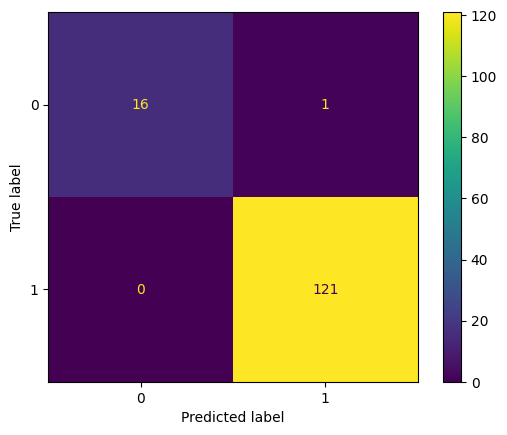

In [24]:
cm_gene_expr = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_gene_expr)
disp.plot()
plt.show()

In [25]:
mystery_dna_meth = pd.read_csv('mystery_dna-meth.csv', sep=',')
mystery_gene_expr = pd.read_csv('mystery_gene-expr.csv', sep=',')

In [26]:
mystery_dna_meth[mystery_dna_meth.columns[2:]] = np.log2(
    mystery_dna_meth[mystery_dna_meth.columns[2:]] + 0.001)
mystery_gene_expr[mystery_gene_expr.columns[2:]] = np.log2(
    mystery_gene_expr[mystery_gene_expr.columns[2:]] + 0.001)

In [27]:
# Define a mapping dictionary
label_mapping = {'Solid Tissue Normal': 0, 'Primary Tumor': 1}

# Use the dictionary to replace the labels in dna_meth
mystery_dna_meth['Label'] = mystery_dna_meth['Label'].replace(label_mapping)

# Use the dictionary to replace the labels in gene_expr
mystery_gene_expr['Label'] = mystery_gene_expr['Label'].replace(label_mapping)

In [28]:
y_true = mystery_dna_meth['Label']
filtered_mystery_dna_meth = mystery_dna_meth[combined_cg_values]

y_pred = clf_dna_meth.predict(filtered_mystery_dna_meth)

In [29]:
print("F1 Score", f1_score(y_true, y_pred))

F1 Score 0.7078651685393258


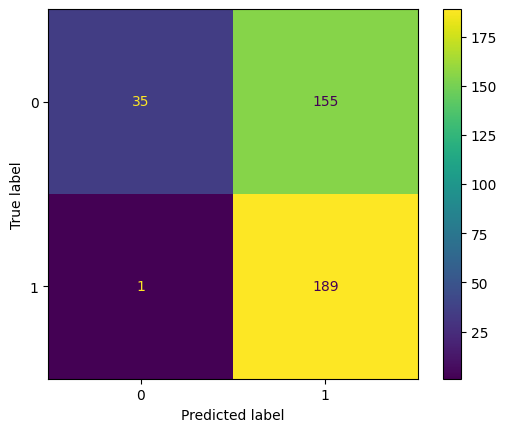

In [30]:
cm_dna_meth_mystery = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_dna_meth_mystery)
disp.plot()
plt.show()

In [31]:
y_true = mystery_gene_expr['Label']
filtered_mystery_gene_expr = mystery_gene_expr[combined_gene_values]
y_pred = clf_gene_expr.predict(filtered_mystery_gene_expr)

In [32]:
print("F1 Score", f1_score(y_true, y_pred))

F1 Score 0.7129455909943715


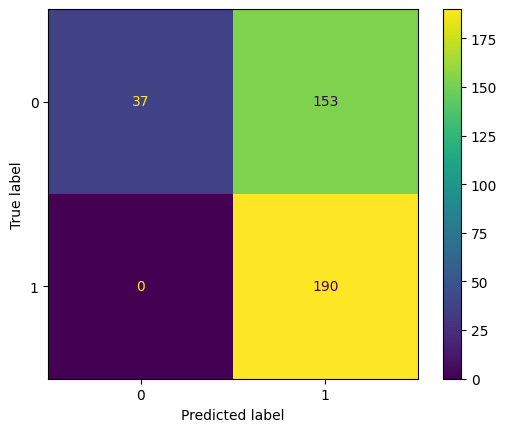

In [33]:
cm_gene_expr_mystery = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_gene_expr_mystery)
disp.plot()
plt.show()